# HBURS, project 2
by Alessandro G. Magnasco

In [1]:
## System imports

# system library
import os

# math & data operations libraries
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from pylab import rcParams # for feature density plotting

# machine learning libraries
import mglearn
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay # sklearn v.1.1
from sklearn.utils import resample

# charting libraries
import matplotlib
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap
%matplotlib inline
import seaborn as sns

# python errors and warnings for debug
import warnings
warnings.filterwarnings('always')  # "error", "ignore", "always", "default", "module" or "once"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126378 entries, 0 to 126377
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   BBL            126378 non-null  int64  
 1   OfficialViols  250 non-null     float64
 2   AEP            250 non-null     float64
 3   RepairCount    44128 non-null   float64
 4   RepairCost     44128 non-null   float64
 5   ClassB_count   110092 non-null  float64
 6   ClassB         110092 non-null  float64
 7   ClassC_count   77014 non-null   float64
 8   ClassC         77014 non-null   float64
 9   SumViols       126378 non-null  float64
 10  ViolsDiff      250 non-null     float64
dtypes: float64(10), int64(1)
memory usage: 10.6 MB


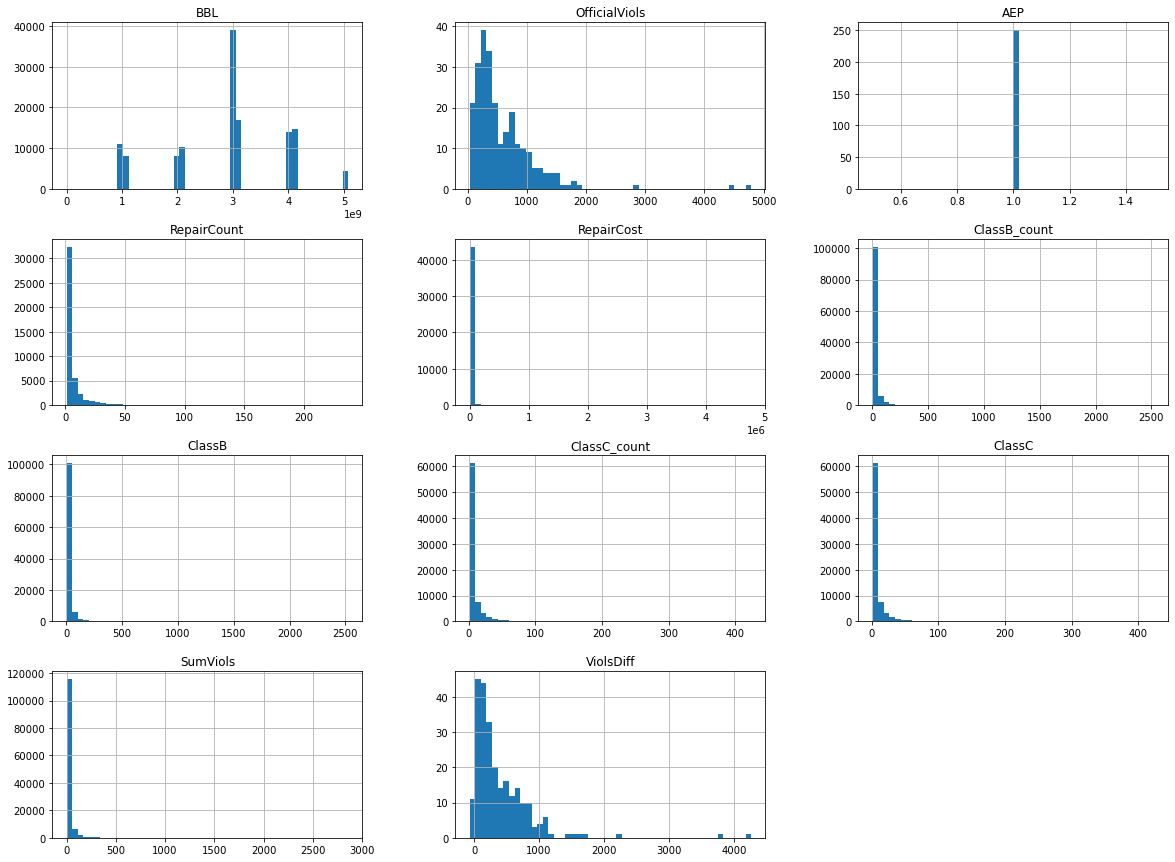

In [2]:
# Step 2.0 - import
bg=0
def import_cleaned_data():
    global bg
    bg = pd.read_csv(r'''bg.csv''', low_memory=False)

import_cleaned_data()
bg.info()

bg.hist(bins=50, figsize=(20,15)) # 20,15
plt.show()

In [3]:
# Step 2.1 - cleaning & split into training/testing

print('Count before dropping NAs: \n',bg.count())
# drop any row that contains any NA value in the parameter columns
bg_dn = bg.dropna(axis=0,how='any', subset=['RepairCost','ClassB','ClassC','RepairCount'])
print('\n\nCount after dropping NAs: \n',bg_dn.count())
# filling remaining NA values with 0
bg_n = bg_dn.fillna(axis=0,value=0)
print(bg_n.head(2000))

# Step 2.2: prepare data, split into features and target
data = bg_n[['RepairCost','ClassB','ClassC','RepairCount']] # selecting features
target = bg_n['AEP'].astype('int8') # this was already established as a dummy

# testing with a smaller sample size
data_small, target_small = resample(data, target, n_samples=500, stratify=target, random_state=4)

Count before dropping NAs: 
 BBL              126378
OfficialViols       250
AEP                 250
RepairCount       44128
RepairCost        44128
ClassB_count     110092
ClassB           110092
ClassC_count      77014
ClassC            77014
SumViols         126378
ViolsDiff           250
dtype: int64


Count after dropping NAs: 
 BBL              32986
OfficialViols      248
AEP                248
RepairCount      32986
RepairCost       32986
ClassB_count     32986
ClassB           32986
ClassC_count     32986
ClassC           32986
SumViols         32986
ViolsDiff          248
dtype: int64
             BBL  OfficialViols  AEP  RepairCount  RepairCost  ClassB_count  \
0     1002050018          186.0  1.0          6.0     6017.00          67.0   
1     1002390011          169.0  1.0          7.0     2286.00          68.0   
3     1003090021          238.0  1.0          4.0     8722.00          75.0   
4     1003100024          108.0  1.0         14.0   105142.37          37.0   
5  

array([[<AxesSubplot:title={'center':'RepairCost'}>,
        <AxesSubplot:title={'center':'ClassB'}>],
       [<AxesSubplot:title={'center':'ClassC'}>,
        <AxesSubplot:title={'center':'RepairCount'}>]], dtype=object)

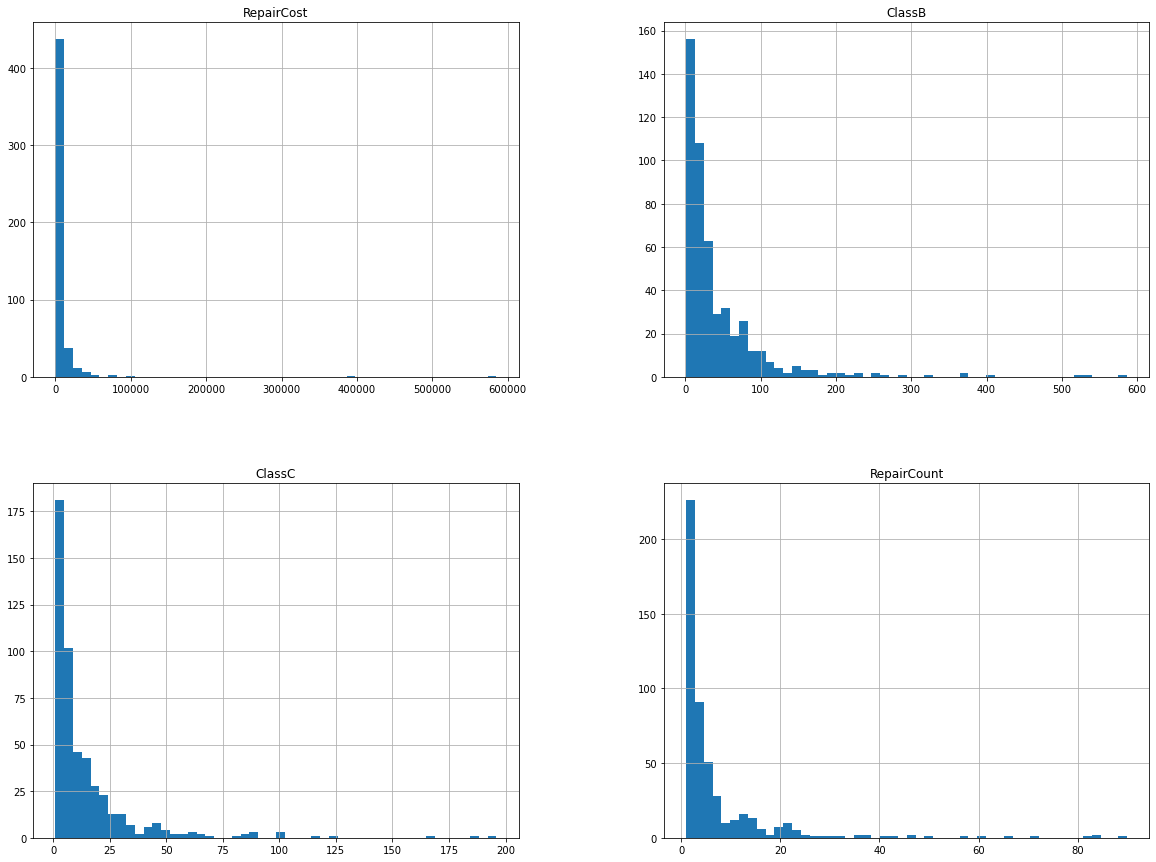

In [9]:
data_small.hist(bins=50, figsize=(20,15)) # 20,15

In [5]:
# quick sanity check
print('If >1, still have NA in data \n',pd.isna(data).nunique())
print('\nData values:\n',data.head())
print('\nIf >1, still have NA in target \n',pd.isna(target).nunique())
print('\nTarget values:\n',target[:5])

If >1, still have NA in data 
 RepairCost     1
ClassB         1
ClassC         1
RepairCount    1
dtype: int64

Data values:
    RepairCost  ClassB  ClassC  RepairCount
0     6017.00    67.0    45.0          6.0
1     2286.00    68.0    30.0          7.0
3     8722.00    75.0    40.0          4.0
4   105142.37    37.0    34.0         14.0
5     3134.00   105.0    23.0          5.0

If >1, still have NA in target 
 1

Target values:
 0    1
1    1
3    1
4    1
5    1
Name: AEP, dtype: int8


In [6]:
# stratified shuffle split
split = StratifiedShuffleSplit(
    n_splits=5, 
    test_size=0.2, # 20% testing and 80% training 
    random_state=4 # RNGs always spit out "4" for me anyway so might as well
)

# using iloc to match the RNG index to the BBL index
for train_index, test_index in split.split(data_small, target_small):
    X_train = data_small.iloc[train_index]
    X_test = data_small.iloc[test_index]
    y_train_d = target_small.iloc[train_index]
    y_test_d = target_small.iloc[test_index]

# converting target sets into 1D arrays
y_train = y_train_d.values.ravel()
y_test = y_test_d.values.ravel()

X_train.describe()

# checking for NA values
print('If !=1, still have NA in X_train \n',pd.isna(X_train).nunique())
print('If !=1, still have NA in X_test \n',pd.isna(X_test).nunique())
print('If !=0, still have NA in y_train \n',np.count_nonzero(np.isnan(y_train)))
print('If !=0, still have NA in y_test \n',np.count_nonzero(np.isnan(y_test)))

If !=1, still have NA in X_train 
 RepairCost     1
ClassB         1
ClassC         1
RepairCount    1
dtype: int64
If !=1, still have NA in X_test 
 RepairCost     1
ClassB         1
ClassC         1
RepairCount    1
dtype: int64
If !=0, still have NA in y_train 
 0
If !=0, still have NA in y_test 
 0


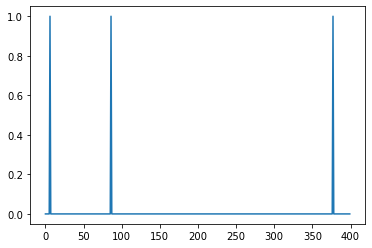

In [10]:
# Step 2.3: examine the target attribute
# Examine and plot the distribution of the target attribute in your training set (e.g., is it Gaussian, uniform, logarithmic). This will help you interpret the performance of different algorithms on your data.

plt.plot(y_train,
         #figsize=(12,8)
        )

(array([397.,   3.]),
 array([0. , 0.5, 1. ]),
 <BarContainer object of 2 artists>)

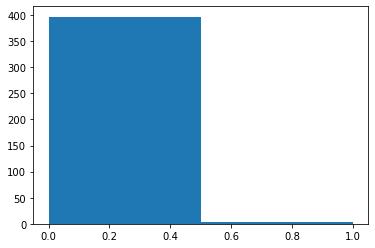

In [12]:
plt.hist(y_train,bins=2,
         #figsize=(12,8)
        ) # we can see that the target attribute is very uneven in distribution

Histogram: 
 [[<AxesSubplot:title={'center':'RepairCost'}>
  <AxesSubplot:title={'center':'ClassB'}>]
 [<AxesSubplot:title={'center':'ClassC'}>
  <AxesSubplot:title={'center':'RepairCount'}>]] 

Scatterplot Matrix: 
 [[<AxesSubplot:xlabel='RepairCost', ylabel='RepairCost'>
  <AxesSubplot:xlabel='ClassB', ylabel='RepairCost'>
  <AxesSubplot:xlabel='ClassC', ylabel='RepairCost'>
  <AxesSubplot:xlabel='RepairCount', ylabel='RepairCost'>]
 [<AxesSubplot:xlabel='RepairCost', ylabel='ClassB'>
  <AxesSubplot:xlabel='ClassB', ylabel='ClassB'>
  <AxesSubplot:xlabel='ClassC', ylabel='ClassB'>
  <AxesSubplot:xlabel='RepairCount', ylabel='ClassB'>]
 [<AxesSubplot:xlabel='RepairCost', ylabel='ClassC'>
  <AxesSubplot:xlabel='ClassB', ylabel='ClassC'>
  <AxesSubplot:xlabel='ClassC', ylabel='ClassC'>
  <AxesSubplot:xlabel='RepairCount', ylabel='ClassC'>]
 [<AxesSubplot:xlabel='RepairCost', ylabel='RepairCount'>
  <AxesSubplot:xlabel='ClassB', ylabel='RepairCount'>
  <AxesSubplot:xlabel='ClassC', ylabe

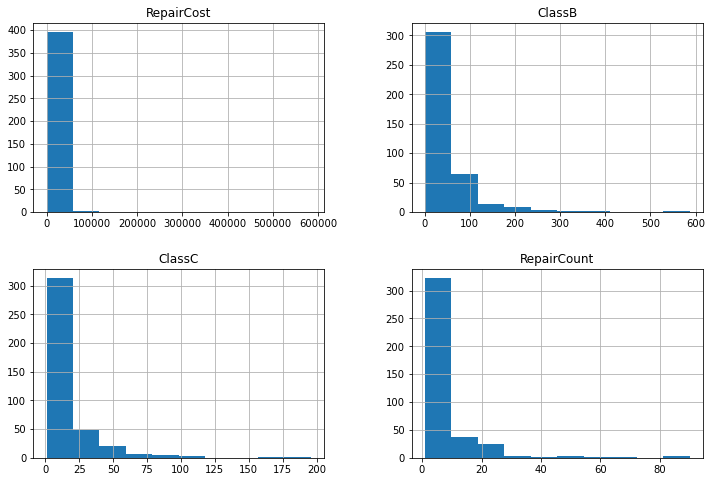

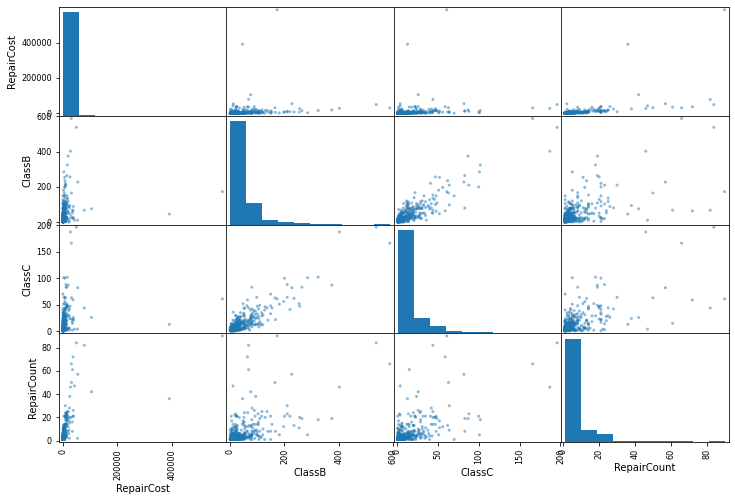

In [13]:
print('Histogram: \n',X_train.hist(figsize=(12,8)),'\n\nScatterplot Matrix: \n',scatter_matrix(X_train, figsize=(12,8)),'\n\n')

             RepairCost    ClassB    ClassC  RepairCount
RepairCost     1.000000  0.185939  0.202286     0.558436
ClassB         0.185939  1.000000  0.888963     0.578091
ClassC         0.202286  0.888963  1.000000     0.624327
RepairCount    0.558436  0.578091  0.624327     1.000000


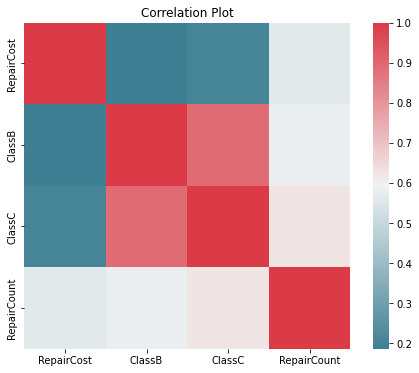

In [14]:
# Pearson correlation matrix
cor= X_train.corr(method='pearson')
print(cor)
fig, ax =plt.subplots(figsize=(8, 6))
plt.title("Correlation Plot")
sns.heatmap(cor, mask=np.zeros_like(cor, dtype=bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

['BBL', 'RepairCount', 'RepairCost', 'ClassB', 'ClassC']


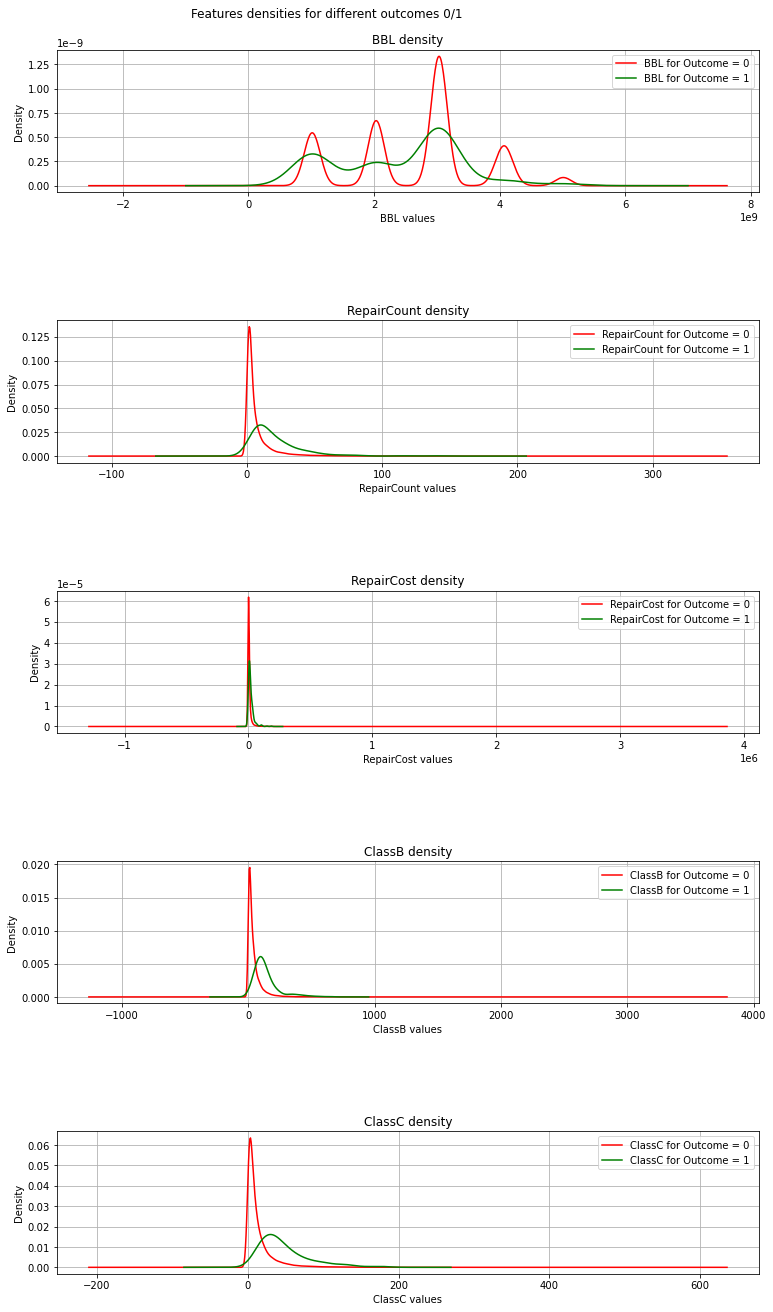

In [15]:
# creating correlation density plots
# this is to try and debug why the models aren't working

# tweaked from @SuperKogito, https://stackoverflow.com/questions/56153726/plot-k-nearest-neighbor-graph-with-8-features

def plot_densities(db):
    # plot size
    rcParams['figure.figsize'] = 15, 20
    # separate data based on outcome values 
    outcome_0 = db[db['AEP'] == 0]
    outcome_1 = db[db['AEP'] == 1]
    # init figure
    fig, axs = plt.subplots(5, 1)
    fig.suptitle('Features densities for different outcomes 0/1')
    plt.subplots_adjust(left = 0.25, right = 0.9, bottom = 0.1, top = 0.95,
                        wspace = 0.2, hspace = 0.9)
    # plot densities for outcomes
    for column_name in names[:]: 
        ax = axs[names.index(column_name)]
        #plt.subplot(4, 2, names.index(column_name) + 1)
        outcome_0[column_name].plot(kind='density', ax=ax, subplots=True, 
                                    sharex=False, color="red", legend=True,
                                    label=column_name + ' for Outcome = 0')
        outcome_1[column_name].plot(kind='density', ax=ax, subplots=True, 
                                     sharex=False, color="green", legend=True,
                                     label=column_name + ' for Outcome = 1')
        ax.set_xlabel(column_name + ' values')
        ax.set_title(column_name + ' density')
        ax.grid('on')
    plt.show()
    fig.savefig('densities.png')

# load your data 
plt_db = bg_n[['AEP','BBL','RepairCount','RepairCost','ClassB','ClassC']]
names = list(plt_db.columns)
names.remove('AEP')
print(names)

# plot correlation & densities
plot_densities(plt_db)

In [16]:
# Step 2.4: apply two different supervised learning algorithms (default parameters)

# k-nearest neighbours
# this model seems a good fit, since we should be able to clearly group buildings in disrepair 
# k = 5
knn_plain = KNeighborsClassifier(n_neighbors=5)
knn_plain.fit(X_train, y_train)
print("knn score: {}".format(knn_plain.score(X_train, y_train)))

knn score: 0.9925


In [17]:
# running the KNN model
knn_pred = knn_plain.predict(X_test)

In [18]:
# gradient-boosted decision tree

# first, tried decision trees.
# this model seemed like a good fit, since there should be a logical hierarchy for the enforcement decision
# we have low-dimensional sparse mixed data, so curious about its performance
# while precision on "no" values was 0.99, precision on "yes" values was 0.06, so opting for random forest instead
# then, tried random forests
# accuracy on both training and test sets was 0.992
# trying to see if I can boost performance with gradient pre-pruning

gbdt = GradientBoostingClassifier(
    n_estimators=200, 
    random_state=0, # for training
    #max_depth=2, # this appears to be optimal
    #learning_rate=0.1 # appears to be optimal
    )
gbdt.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gbdt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbdt.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.990


In [19]:
# running the GBDT model
gbdt_pred = gbdt.predict(X_test)

In [20]:
# the feature importances of the random forest:

print("Feature importances:")
print(gbdt.feature_importances_)

Feature importances:
[0.05811671 0.81229898 0.10658529 0.02299902]


In [21]:
# support vector machine
# this model seems a good fit, since the level of building disrepair could lend itself to a support hyperplane
# would require MinMaxScaler and VarianceThreshold before using, so leaving for future work

### Step 2.5: parameter adjustment

In [22]:
# k-nearest neighbours
# precision, recall, and F1 before adjusting
print(classification_report(y_test, knn_plain.predict(X_test),
                            target_names=["No AEP", "Yes AEP"]))

              precision    recall  f1-score   support

      No AEP       0.99      1.00      0.99        99
     Yes AEP       0.00      0.00      0.00         1

    accuracy                           0.99       100
   macro avg       0.49      0.50      0.50       100
weighted avg       0.98      0.99      0.99       100



C:\Users\Ale\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ale\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ale\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
# the initial model was telling me it couldn't find any values where it predicted AEP=1
# trying to debug

# the set of labels KNN found
set(knn_pred)

{0}

In [24]:
# so adjusting parameters using grid search
knn_seasoned = KNeighborsClassifier()
knn_param_grid = {"n_neighbors": np.arange(1, 25)} # setting boundaries on k

# grid search on all values of k in dictionary
knn_gscv = GridSearchCV(knn_seasoned, knn_param_grid, cv=5)
knn_gscv.fit(X_train, y_train)
print('\n\nBest parameters: ',knn_gscv.best_params_)

C:\Users\Ale\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(




Best parameters:  {'n_neighbors': 2}


In [25]:
# report evaluation metrics for best- and worst- performing parameter settings
print(classification_report(y_test, knn_gscv.predict(X_test),
                            target_names=["No AEP", "Yes AEP"]))

              precision    recall  f1-score   support

      No AEP       0.99      1.00      0.99        99
     Yes AEP       0.00      0.00      0.00         1

    accuracy                           0.99       100
   macro avg       0.49      0.50      0.50       100
weighted avg       0.98      0.99      0.99       100



C:\Users\Ale\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ale\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ale\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
# trying to figure out why the model does not make any positive predictions
disp = DecisionBoundaryDisplay.from_estimator(
    knn_gscv, X_train, response_method="predict",
    alpha=0.5,
)
disp.ax_.scatter(X[:, 0], X[:, 1], c=iris.target, edgecolor="k")

plt.show()

ValueError: Input X contains NaN.
KNeighborsClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
# gradient-boosted random forest
# precision, recall, and F1
print(classification_report(y_test, gbrt.predict(X_test),
                            target_names=["No AEP", "Yes AEP"]))

In [ ]:
# adjust 2-3 parameters using grid search
gbrt_seasoned = RandomForestClassifier(random_state=4)

# creating a dictionary with boundaries for each grid search parameter
gbrt_param_grid = { 
    'n_estimators': [200, 300, 400, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1,2,3,4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

gbrt_gscv = GridSearchCV(estimator=gbrt_seasoned, param_grid=gbrt_param_grid, cv=5)
gbrt_gscv.fit(X_train, y_train)

gbrt_gscv.best_params_

In [ ]:
# report evaluation metrics for best- and worst- performing parameter settings
print(classification_report(y_test, gbrt_gscv.predict(X_test),
                            target_names=["No AEP", "Yes AEP"]))